In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam


In [ ]:
# Cargar datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0

In [ ]:
# Define convolutional neural network model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

# Initialize two separate networks
red = build_model()
mascara = build_model()

# Compile models
red.compile(loss='sparse_categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy'])
mascara.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])


In [ ]:
# Función para activar el 30% de los pesos más altos en la máscara
def activate_top_weights(model, percentage):
    weights = model.get_weights()
    flat_weights = np.concatenate([w.flatten() for w in weights])
    threshold = np.percentile(flat_weights, 100 - percentage)
    mask = [abs(w) >= threshold for w in weights]
    model.set_weights([m * w for m, w in zip(mask, weights)])


In [ ]:
# Entrenamiento de los modelos
accuracy = 0
epochs = 0
history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
while accuracy < 0.6:
    epochs += 1
    print("Epoch:", epochs)
    
    # Entrenar red con datos de entrenamiento
    red.fit(x_train, y_train, epochs=1, batch_size=128, validation_split=0.1, verbose=0)
    # Evaluar red en datos de validación
    val_loss, val_accuracy = red.evaluate(x_test, y_test, verbose=0)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    # Calcular error de red y retropropagarlo en la máscara
    loss = red.evaluate(x_train, y_train, verbose=0)[0]
    predictions = red.predict(x_train)
    red_gradients = red.optimizer.get_gradients(loss=loss, params=red.trainable_weights)
    with tf.GradientTape() as tape:
        tape.watch(mascara.trainable_weights)
        masked_outputs = mascara(x_train)
        masked_loss = keras.losses.sparse_categorical_crossentropy(y_train, masked_outputs)
    gradients = tape.gradient(masked_loss, mascara.trainable_weights)
    mascara.optimizer.apply_gradients(zip(gradients, mascara.trainable_weights))
    
    print("Accuracy:", val_accuracy)
    print("Loss:", loss)
    
    # Activar el 30% de los pesos más altos en la máscara
    activate_top_weights(mascara, 30)
    
    accuracy = val_accuracy
    history['accuracy'].append(accuracy)
    history['loss'].append(loss)



Epoch: 1
Accuracy: 0.9789000153541565
Loss: 0.07943268120288849


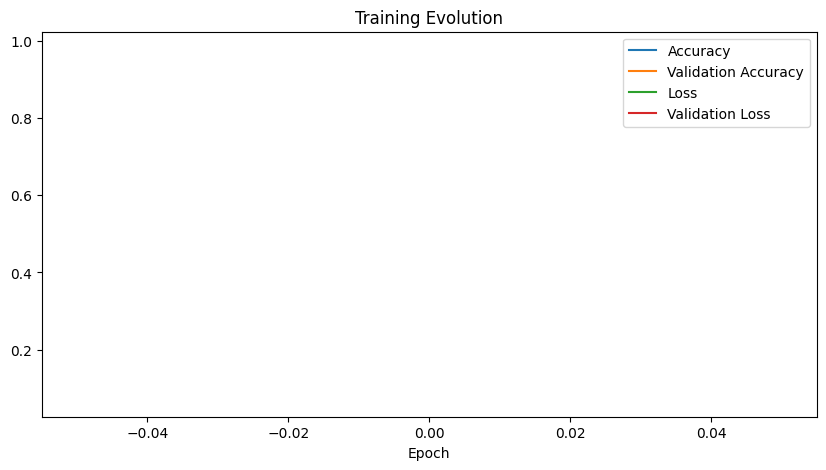

In [ ]:
# Gráfica de evolución del error y el acierto en validación
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training Evolution')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Evaluar el modelo en datos de prueba
test_loss, test_accuracy = red.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9754 - loss: 0.0819
Test Accuracy: 0.9789000153541565


: 